<a href="https://colab.research.google.com/github/hosein-jamshidian/Sentiment_Analyses_SnappFood/blob/main/sentiment_Analysis_snappfood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, ConfusionMatrixDisplay
from sklearn.utils import shuffle

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import tqdm

import re
import os



In [2]:
!pip install hazm
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.8/352.8 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 82.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 kB 23.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.25.1 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.25.1 which is incompatible.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 66.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.4 MB/s eta 0:00:00


In [3]:
from transformers import BertConfig, BertTokenizer
from transformers import BertModel

from transformers import AdamW
import hazm

## Load Data

In [4]:
!unzip /content/DL-HW3.zip
!rm /content/DL-HW3.zip
!rm /content/DL-HW3/DL-HW3-Description.pdf

Archive:  /content/DL-HW3.zip
  inflating: DL-HW3/DL-HW3-Description.pdf  
   creating: DL-HW3/Snappfood-Dataset/
  inflating: DL-HW3/Snappfood-Dataset/dev.csv  
  inflating: DL-HW3/Snappfood-Dataset/test.csv  
  inflating: DL-HW3/Snappfood-Dataset/train.csv  


In [5]:
train_df=pd.read_csv('/content/DL-HW3/Snappfood-Dataset/train.csv',sep='\t',index_col=0)
val_df=pd.read_csv('/content/DL-HW3/Snappfood-Dataset/dev.csv',sep='\t',index_col=0)
test_df=pd.read_csv('/content/DL-HW3/Snappfood-Dataset/test.csv',sep='\t',index_col=0)

In [6]:
# use strio function to fix the sentences if have a issue with sentnce structure.

train_df['comment']=train_df['comment'].apply(lambda x: x.strip())
val_df['comment']=val_df['comment'].apply(lambda x: x.strip())
test_df['comment']=test_df['comment'].apply(lambda x: x.strip())

In [7]:
print(f'the shape of training set is :{train_df.shape}\nand the shape of validation set is :{val_df.shape}\nand the shape of test set is :{test_df.shape}')

the shape of training set is :(56700, 3)
and the shape of validation set is :(6300, 3)
and the shape of test set is :(7000, 3)


In [8]:
label2id={'SAD': 1, 'HAPPY': 0}
id2label={0:'HAPPY',1:'SAD'}

## visualization

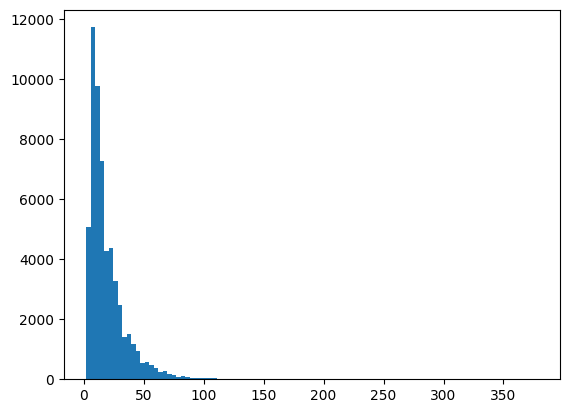

In [9]:
train_df['sent_len']=train_df['comment'].apply(lambda x : len(hazm.word_tokenize(x)))

plt.hist(train_df['sent_len'], bins=100)
plt.show()

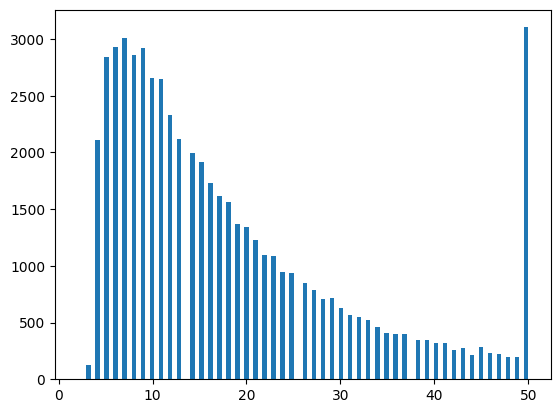

In [10]:
COMMENT_MAX_LEN=50
train_df['sent_len']=train_df['comment'].apply(lambda x : len(hazm.word_tokenize(x)[:COMMENT_MAX_LEN]))

plt.hist(train_df['sent_len'], bins=100)
plt.show()

# Preprocessing

In [11]:
def cleaning(sent):
  wierd_pattern=re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        u"\u2069"
        u"\u2066"
        u"\u200c"
        u"\u2068"
        u"\u2067"
        "]+", flags=re.UNICODE)
  sent = wierd_pattern.sub(r'', sent)

  sent = re.sub("#", "", sent)
  sent = re.sub("\s+", " ", sent)

  return sent

In [12]:
normalizer=hazm.Normalizer()

train_df['comment']= train_df['comment'].apply(lambda x : normalizer.normalize(x))
val_df['comment']= val_df['comment'].apply(lambda x : normalizer.normalize(x))
test_df['comment']= test_df['comment'].apply(lambda x : normalizer.normalize(x))

In [13]:
train_df['comment']= train_df['comment'].apply(cleaning)
val_df['comment']= val_df['comment'].apply(cleaning)
test_df['comment']= test_df['comment'].apply(cleaning)

In [14]:
train_df = train_df[['comment', 'label_id']]
val_df = val_df[['comment', 'label_id']]
test_df = test_df[['comment', 'label_id']]

In [15]:
# convert the label_id type to integer

train_df['label_id'] = train_df['label_id'].astype(int)
val_df['label_id'] = val_df['label_id'].astype(int)
test_df['label_id'] = test_df['label_id'].astype(int)

<ipython-input-15-5b85eb7ba2cc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['label_id'] = train_df['label_id'].astype(int)
<ipython-input-15-5b85eb7ba2cc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['label_id'] = val_df['label_id'].astype(int)
<ipython-input-15-5b85eb7ba2cc>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

In [16]:
train_df.head()

,comment,label_id
0,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,1
1,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,0
2,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,1
3,عالی بود همه چه درست و به اندازه و کیفیت خوب، ...,0
4,شیرینی وانیلی فقط یک مدل بود.,0


# Bert Configuration

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'device: {device}')

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

device: cuda:0
CUDA is available!  Training on GPU ...


In [18]:
CLIP = 0.0

MODEL_NAME_OR_PATH = 'HooshvareLab/bert-fa-base-uncased-sentiment-snappfood'
OUTPUT_PATH = '/content/bert-fa-base-uncased-sentiment-snappfood/pytorch_model.bin'

os.makedirs(os.path.dirname(OUTPUT_PATH), exist_ok=True)

In [19]:
# Bert Tokenizer that pretrain on snappfood data
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME_OR_PATH)

In [20]:
config = BertConfig.from_pretrained(
    MODEL_NAME_OR_PATH, **{
        'label2id': label2id,
        'id2label': id2label,
    })

print(config.to_json_string())

{
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "finetuning_task": "snappfood",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "HAPPY",
    "1": "SAD"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "HAPPY": 0,
    "SAD": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.30.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 100000
}



In [21]:
# sample that show us how to convert tokens to indexes
idx = np.random.randint(0, len(train_df))

sample_comment = train_df.iloc[idx]['comment']
sample_label = train_df.iloc[idx]['label_id']

print(f'Sample: \n{sample_comment}\n{sample_label}')

tokens = tokenizer.tokenize(sample_comment)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'  Comment: {sample_comment}')
print(f'   Tokens: {tokenizer.convert_tokens_to_string(tokens)}')
print(f'Token IDs: {token_ids}')

Sample: 
راضی بودم از نانها، همانطور که گفته بودم، برشته و نازک بودند و خمیر نشده بودند تا به دستم برسه
0
  Comment: راضی بودم از نانها، همانطور که گفته بودم، برشته و نازک بودند و خمیر نشده بودند تا به دستم برسه
   Tokens: راضی بودم از نانها ، همانطور که گفته بودم ، برشته و نازک بودند و خمیر نشده بودند تا به دستم برسه
Token IDs: [8629, 6084, 2791, 40291, 1348, 5785, 2800, 3538, 6084, 1348, 27678, 1379, 10866, 3339, 1379, 11065, 4338, 3339, 2848, 2789, 22247, 43170]


In [22]:
encoding = tokenizer.encode_plus(
    sample_comment,
    max_length=COMMENT_MAX_LEN,
    truncation=True,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=True,
    return_attention_mask=True,
    padding='max_length',
    return_tensors='pt',  # Return PyTorch tensors
)

print(f'Keys: {encoding.keys()}\n')
for k in encoding.keys():
    print(f'{k}:\n{encoding[k]}')

Keys: dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

input_ids:
tensor([[    2,  8629,  6084,  2791, 40291,  1348,  5785,  2800,  3538,  6084,
          1348, 27678,  1379, 10866,  3339,  1379, 11065,  4338,  3339,  2848,
          2789, 22247, 43170,     4,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]])
token_type_ids:
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])
attention_mask:
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])


In [23]:
from torch.utils.data import Dataset, DataLoader

In [24]:
# the class use for create embedding vector and encoding layer
class SnappFoodDataset(Dataset):
    def __init__(self, tokenizer, dataframe):
        self.dataframe = dataframe
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        item = self.dataframe.iloc[idx]
        comment = item['comment']
        label = item['label_id']

        encoding = self.tokenizer.encode_plus(
            comment,
            add_special_tokens=True,
            truncation=True,
            max_length=COMMENT_MAX_LEN,
            return_token_type_ids=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt')

        return {
                'comment': comment,
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'token_type_ids': encoding['token_type_ids'].flatten(),
                'label': int(label),
                }

In [25]:
train_dataset = SnappFoodDataset(tokenizer, train_df)
val_dataset = SnappFoodDataset(tokenizer, val_df)
test_dataset = SnappFoodDataset(tokenizer, test_df)

In [26]:
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16


train_dataloder = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE)
val_dataloder = DataLoader(val_dataset, batch_size=VALID_BATCH_SIZE)
test_dataloder = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE)

In [27]:
bert = BertModel.from_pretrained('HooshvareLab/bert-fa-base-uncased-sentiment-snappfood')

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased-sentiment-snappfood were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [28]:
bert=BertModel.from_pretrained('HooshvareLab/bert-fa-base-uncased-sentiment-snappfood')

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased-sentiment-snappfood were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [29]:
bert = bert.eval().to(device)

In [30]:
bert

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(100000, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
 

In [31]:
bert_outputs_train = torch.zeros(len(train_df), 768)
bert_outputs_val = torch.zeros(len(val_df), 768)
bert_outputs_test = torch.zeros(len(test_df), 768)

# training with pretrain Bert model

In [32]:
# Training feature extraction
i = 0
for batch in tqdm(train_dataloder):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    token_type_ids = batch['token_type_ids'].to(device)
    # print(token_type_ids)
    with torch.no_grad():
        out = bert(input_ids, attention_mask, token_type_ids)['pooler_output'].cpu()
        # print( bert(input_ids, attention_mask, token_type_ids)['pooler_output'].cpu)

    # out.size(0)=16
    bert_outputs_train[i: i + out.size(0)] = out
    i += out.size(0)

  0%|          | 0/3544 [00:00<?, ?it/s]

In [33]:
# Validation feature extraction
i = 0
for batch in tqdm(val_dataloder):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    token_type_ids = batch['token_type_ids'].to(device)

    with torch.no_grad():
        out = bert(input_ids, attention_mask, token_type_ids)['pooler_output'].cpu()

    bert_outputs_val[i: i + out.size(0)] = out
    i += out.size(0)

  0%|          | 0/394 [00:00<?, ?it/s]

In [34]:
# Test feature extraction
i = 0
for batch in tqdm(test_dataloder):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    token_type_ids = batch['token_type_ids'].to(device)

    with torch.no_grad():
        out = bert(input_ids, attention_mask, token_type_ids)['pooler_output'].cpu()

    bert_outputs_test[i: i + out.size(0)] = out
    i += out.size(0)

  0%|          | 0/438 [00:00<?, ?it/s]

#Dimention Decomposition

In [35]:
from sklearn.decomposition import PCA

In [36]:
bert_outputs_train = bert_outputs_train.numpy()
bert_outputs_val = bert_outputs_val.numpy()
bert_outputs_test = bert_outputs_test.numpy()


In [37]:
bert_outputs_train.shape

(56700, 768)

In [38]:
dimentin_reduction = PCA(n_components=2)

bert_outputs_train_2d = dimentin_reduction.fit_transform(bert_outputs_train)
bert_outputs_val_2d = dimentin_reduction.transform(bert_outputs_val)
bert_outputs_test_2d = dimentin_reduction.transform(bert_outputs_test)

In [39]:
l=[]
for i in range(1,10):
    pca1=PCA(n_components=i).fit(bert_outputs_train)
    l.append(pca1.explained_variance_ratio_[-1])

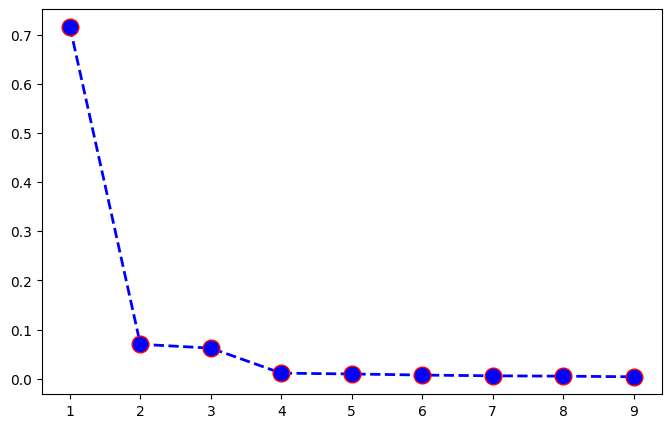

In [40]:
plt.figure(figsize=(8,5))
plt.plot(range(1,10),l,lw=2,ls="--",marker="o",markeredgecolor="red",color="blue",markersize=12)

In [41]:
bert_outputs_train_2d.shape

(56700, 2)

Text(0.5, 1.0, 'Train data')

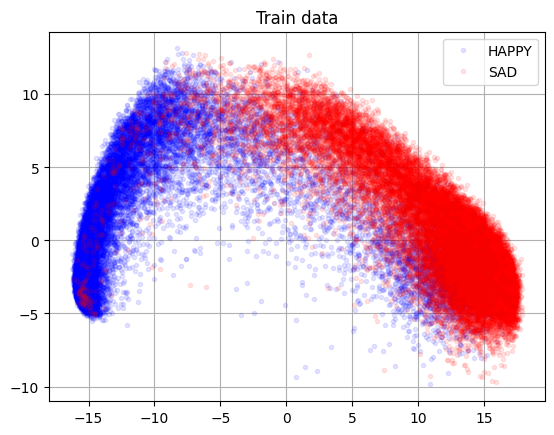

In [42]:
plt.plot(bert_outputs_train_2d[train_df['label_id'] == 0, 0], bert_outputs_train_2d[train_df['label_id'] == 0, 1], 'b.', alpha=0.1, label='HAPPY')
plt.plot(bert_outputs_train_2d[train_df['label_id'] == 1, 0], bert_outputs_train_2d[train_df['label_id'] == 1, 1], 'r.', alpha=0.1, label='SAD')
plt.grid()
plt.legend()
plt.title('Train data')

Text(0.5, 1.0, 'Validation data')

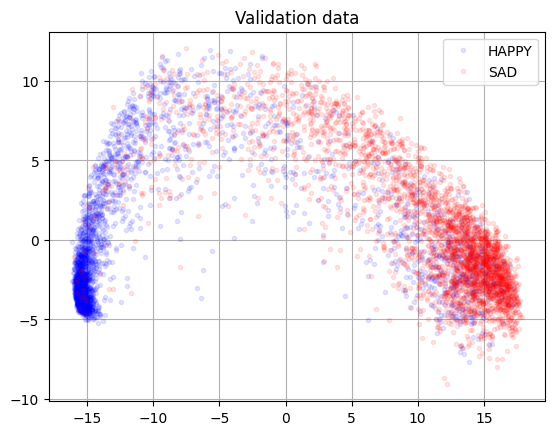

In [43]:
plt.plot(bert_outputs_val_2d[val_df['label_id'] == 0, 0], bert_outputs_val_2d[val_df['label_id'] == 0, 1], 'b.', alpha=0.1, label='HAPPY')
plt.plot(bert_outputs_val_2d[val_df['label_id'] == 1, 0], bert_outputs_val_2d[val_df['label_id'] == 1, 1], 'r.', alpha=0.1, label='SAD')
plt.grid()
plt.legend()
plt.title('Validation data')

Text(0.5, 1.0, 'Test data')

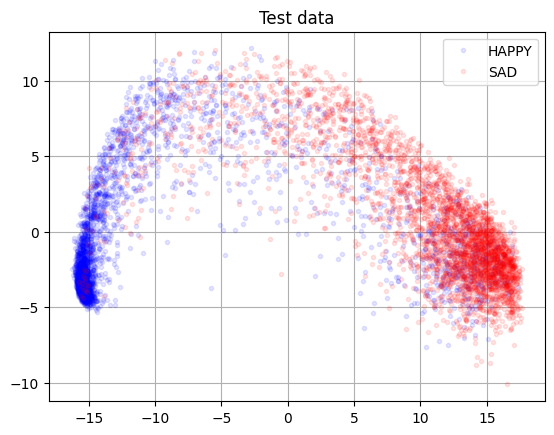

In [44]:
plt.plot(bert_outputs_test_2d[test_df['label_id'] == 0, 0], bert_outputs_test_2d[test_df['label_id'] == 0, 1], 'b.', alpha=0.1, label='HAPPY')
plt.plot(bert_outputs_test_2d[test_df['label_id'] == 1, 0], bert_outputs_test_2d[test_df['label_id'] == 1, 1], 'r.', alpha=0.1, label='SAD')
plt.grid()
plt.legend()
plt.title('Test data')

# use logestic regression model one tensor extrct from Bert training  

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score,classification_report

# train , predict and evaluate on bert output train data that pca implement on it.

In [46]:
clf_on_pca = LogisticRegression()
clf_on_pca.fit(bert_outputs_train_2d, train_df['label_id'])

LogisticRegression()

In [47]:
pred_train_on_pca = clf_on_pca.predict(bert_outputs_train_2d)
pred_test_on_pca= clf_on_pca.predict(bert_outputs_test_2d)

In [48]:
print(classification_report(train_df['label_id'], pred_train_on_pca))

              precision    recall  f1-score   support

           0       0.97      0.90      0.93     28350
           1       0.91      0.97      0.94     28350

    accuracy                           0.94     56700
   macro avg       0.94      0.94      0.94     56700
weighted avg       0.94      0.94      0.94     56700



In [49]:
print(classification_report(test_df['label_id'], pred_test_on_pca))

              precision    recall  f1-score   support

           0       0.91      0.84      0.87      3500
           1       0.85      0.92      0.88      3500

    accuracy                           0.88      7000
   macro avg       0.88      0.88      0.88      7000
weighted avg       0.88      0.88      0.88      7000



# training and prediction on test , train and validation data that pca not implement on it.

In [50]:
clf = LogisticRegression()
clf.fit(bert_outputs_train, train_df['label_id'])

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [51]:
pred_train = clf.predict(bert_outputs_train)
pred_val = clf.predict(bert_outputs_val)
pred_test = clf.predict(bert_outputs_test)

#evaluation

In [52]:
print(classification_report(train_df['label_id'], pred_train))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95     28350
           1       0.94      0.96      0.95     28350

    accuracy                           0.95     56700
   macro avg       0.95      0.95      0.95     56700
weighted avg       0.95      0.95      0.95     56700



In [53]:
print(classification_report(val_df['label_id'], pred_val))

              precision    recall  f1-score   support

           0       0.87      0.84      0.85      3150
           1       0.84      0.88      0.86      3150

    accuracy                           0.86      6300
   macro avg       0.86      0.86      0.86      6300
weighted avg       0.86      0.86      0.86      6300



In [54]:
print(classification_report(test_df['label_id'], pred_test))

              precision    recall  f1-score   support

           0       0.87      0.86      0.87      3500
           1       0.86      0.88      0.87      3500

    accuracy                           0.87      7000
   macro avg       0.87      0.87      0.87      7000
weighted avg       0.87      0.87      0.87      7000



# create a model for bert and justify them hyperparameters

In [51]:
config

BertConfig {
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "finetuning_task": "snappfood",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "HAPPY",
    "1": "SAD"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "HAPPY": 0,
    "SAD": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.30.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 100000
}

In [52]:
from transformers.pipelines import zero_shot_classification


class SnappFoodModel(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.bert = BertModel.from_pretrained(MODEL_NAME_OR_PATH)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, 1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        z = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids)

        pooled_output = self.dropout(z['pooler_output'])
        out = self.classifier(pooled_output)
        return out

In [53]:
sf_model = SnappFoodModel(config=config)
sf_model = sf_model.to(device)

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased-sentiment-snappfood were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [54]:
sf_model

SnappFoodModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [55]:
# train model

In [56]:
def score_model(y_true, y_pred):
    # y_pred after sigmoid
    return {'acc': accuracy_score(y_true, y_pred > 0),
            'f1-score': f1_score(y_true, y_pred > 0),
    }


In [57]:
def train_model(model, dataloaders, criterion, optimizer, epochs, valid_steps=1000):
    train_history = {'loss': [], 'accuracy': [], 'f1-score': []}
    valid_history = {'loss': [], 'accuracy': [], 'f1-score': []}

    for epoch in range(epochs):
        sum_loss_train = 0
        sum_acc_train = 0
        sum_f1_train = 0
        train_steps = 0
        model.train()
        for batch in tqdm(dataloaders['train']):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            label = batch['label'].to(device).view(-1, 1).float()

            optimizer.zero_grad()
            output = model(input_ids, attention_mask, token_type_ids)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()

            sum_loss_train += loss.item()
            output = F.sigmoid(output.detach())
            metrics = score_model(label.cpu().numpy(), output.cpu().numpy())
            sum_acc_train += metrics['acc']
            sum_f1_train += metrics['f1-score']
            train_steps += 1

            if train_steps % valid_steps == 0:
                print('Validation...')
                sum_loss_valid = 0
                sum_acc_valid = 0
                sum_f1_valid = 0
                validation_steps = 0
                model.eval()
                for batch in tqdm(dataloaders['valid']):
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    token_type_ids = batch['token_type_ids'].to(device)
                    label = batch['label'].to(device).view(-1, 1).float()

                    with torch.no_grad():
                        output = model(input_ids, attention_mask, token_type_ids)
                        loss = criterion(output, label)

                        sum_loss_valid += loss.item()
                        output = F.sigmoid(output)
                        metrics = score_model(label.cpu().numpy(), output.cpu().numpy())
                        sum_acc_valid += metrics['acc']
                        sum_f1_valid += metrics['f1-score']
                        validation_steps += 1

                train_history['loss'].append(sum_loss_train / train_steps)
                train_history['accuracy'].append(sum_acc_train / train_steps)
                train_history['f1-score'].append(sum_f1_train / train_steps)

                valid_history['loss'].append(sum_loss_valid / validation_steps)
                valid_history['accuracy'].append(sum_acc_valid / validation_steps)
                valid_history['f1-score'].append(sum_f1_valid / validation_steps)

                sum_loss_train = 0
                sum_acc_train = 0
                sum_f1_train = 0
                train_steps = 0

    return model, train_history, valid_history

In [64]:
# Part1, training classifier

dataloders = {
    'train': train_dataloder,
    'valid': val_dataloder
}

criterion = nn.BCEWithLogitsLoss()

sf_model.bert.requires_grad_ = False

optimizer = torch.optim.Adam(sf_model.classifier.parameters() ,lr=0.001)

sf_model, history_train, history_valid = train_model(sf_model, dataloders, criterion, optimizer, epochs=5)

  0%|          | 0/3544 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

  0%|          | 0/3544 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

  0%|          | 0/3544 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

  0%|          | 0/3544 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

  0%|          | 0/3544 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Loss')

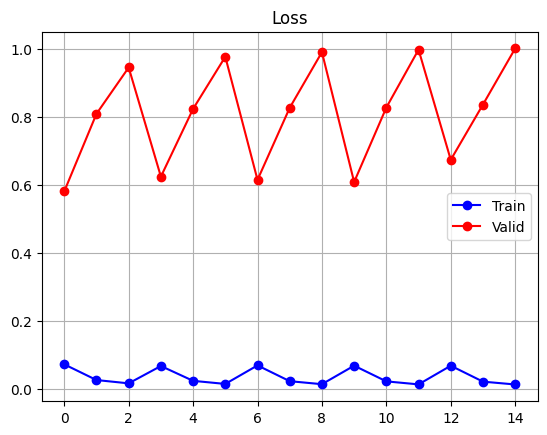

In [65]:
plt.plot(history_train['loss'], 'bo-', label='Train')
plt.plot(history_valid['loss'], 'ro-', label='Valid')
plt.grid()
plt.legend()
plt.title('Loss')

Text(0.5, 1.0, 'Accuracy')

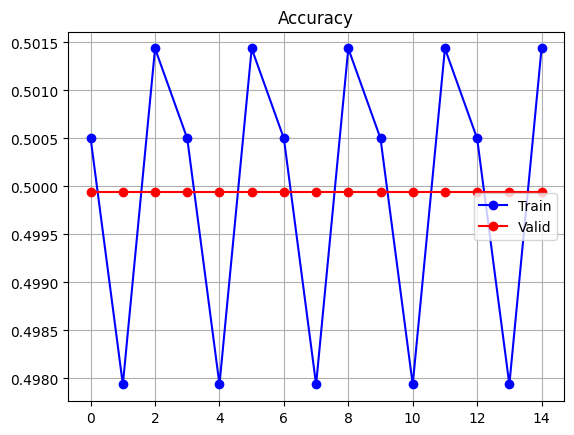

In [66]:
plt.plot(history_train['accuracy'], 'bo-', label='Train')
plt.plot(history_valid['accuracy'], 'ro-', label='Valid')
plt.grid()
plt.legend()
plt.title('Accuracy')

Text(0.5, 1.0, 'F1-score')

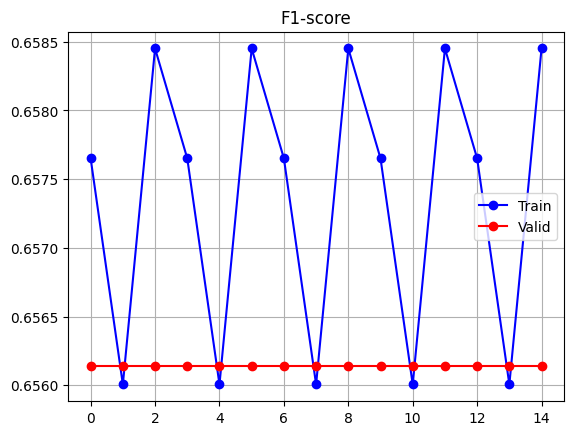

In [67]:

plt.plot(history_train['f1-score'], 'bo-', label='Train')
plt.plot(history_valid['f1-score'], 'ro-', label='Valid')
plt.grid()
plt.legend()
plt.title('F1-score')

In [97]:
# Part2, finetuning

dataloders = {
    'train': train_dataloder,
    'valid': val_dataloder
}

criterion = nn.BCEWithLogitsLoss()
sf_model.bert.requires_grad_ = True
optimizer = torch.optim.AdamW(sf_model.parameters() ,lr=0.00001)

sf_model, history_train, history_valid = train_model(sf_model, dataloders, criterion, optimizer, epochs=5)

  0%|          | 0/3544 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

  0%|          | 0/3544 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

  0%|          | 0/3544 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

  0%|          | 0/3544 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

  0%|          | 0/3544 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Validation...


  0%|          | 0/394 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Loss')

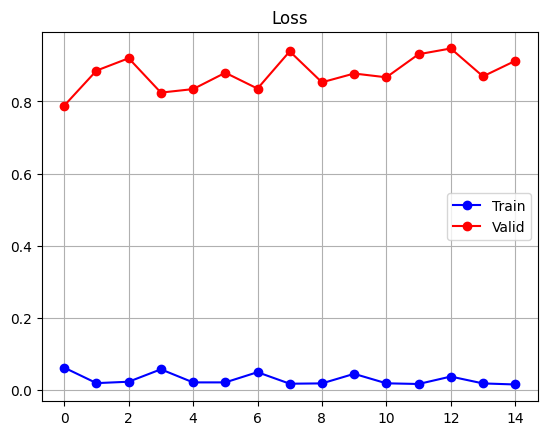

In [98]:
plt.plot(history_train['loss'], 'bo-', label='Train')
plt.plot(history_valid['loss'], 'ro-', label='Valid')
plt.grid()
plt.legend()
plt.title('Loss')

Text(0.5, 1.0, 'Accuracy')

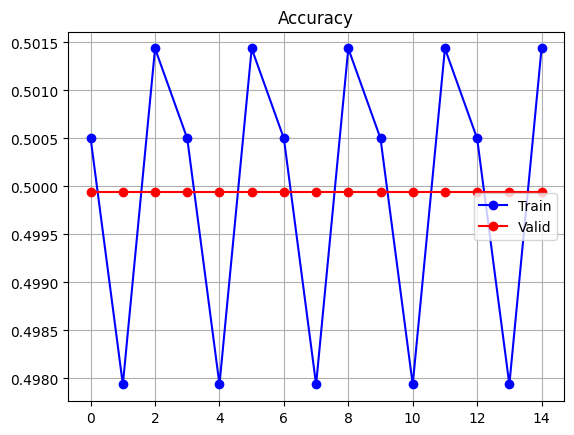

In [99]:
plt.plot(history_train['accuracy'], 'bo-', label='Train')
plt.plot(history_valid['accuracy'], 'ro-', label='Valid')
plt.grid()
plt.legend()
plt.title('Accuracy')

# play with wrong labels on test data

In [63]:
#final

id2label

{0: 'HAPPY', 1: 'SAD'}

In [68]:
h_test=clf.predict_proba(bert_outputs_test)

In [69]:
test_df_error=test_df.copy()

In [70]:
test_df_error['sad_pred']=pred_test
test_df_error['sad_prob']=h_test[:,1]

In [71]:
sad_df=test_df_error[test_df_error['label_id']==1].sort_values('sad_prob')

In [89]:
sad_df.head()

,comment,label_id,sad_pred,sad_prob
4328,عالی بود پیشنهاد میکنم,1,0,0.002168
797,درود بر شما حجم پیتزا خوب بود. یک مقدار از پیت...,1,0,0.002530
2156,چیزکیک کمی بیات بود,1,0,0.002998
4234,عذم ارسال کوپن پوره سیبزمینی توسط گاردن گریل,1,0,0.003075
6878,کیفیت خیلی عالی بود، خوشطعم، ترد و خوشمزه خیلی...,1,0,0.003206


In [73]:
happy_df = test_df_error[test_df_error['label_id'] == 0].sort_values('sad_prob',ascending=False)

In [74]:
happy_df.head()

,comment,label_id,sad_pred,sad_prob
672,غذا سرد و بی طعم تیکههای سوسیس خام بودن برند س...,0,1,0.999554
483,با اینکه تو نظرات خونده بودم جوجهکباب با استخو...,0,1,0.999380
6776,برگر کاملا خشکشده بود و پیتزا که اصلا مواد ندا...,0,1,0.999112
1489,متاسفانه چنجه خوب نپخته بود و مغزپخت نشده بود....,0,1,0.998812
1875,اگر میشد به اسنپ فود امتیاز صفر میدادم نزدیک ۲...,0,1,0.998722


## fix the labels_id values of test dataset

In [75]:
test_df_new=test_df.copy()

In [76]:
# convert the label of sentences that have sad probability more than %90 and take happy label  to sad.

# test_df_new.loc[happy_df[happy_df['sad_prob']>.90].index]['label_id']=1
test_df_new.loc[happy_df[happy_df['sad_prob'] > 0.90].index, 'label_id'] = 1

# point : convert sentences with sad label and very low sad probability to happy label is not improve accuracy so much/.
# test_df_new.loc[sad_df[sad_df['sad_prob'] < 0.003616].index, 'label_id'] = 0

In [77]:
test_dataset_new = SnappFoodDataset(tokenizer, test_df_new)
test_dataloder_new = DataLoader(test_dataset_new, batch_size=TEST_BATCH_SIZE)
bert_outputs_test_new = torch.zeros(len(test_df_new), 768)

# Using New Clear Test Dataset for predicting and evaluation

In [78]:
# Test feature extraction
i = 0
for batch in tqdm(test_dataloder_new):
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    token_type_ids = batch['token_type_ids'].to(device)

    with torch.no_grad():
        out = bert(input_ids, attention_mask, token_type_ids)['pooler_output'].cpu()

    bert_outputs_test_new[i: i + out.size(0)] = out
    i += out.size(0)

  0%|          | 0/438 [00:00<?, ?it/s]

In [79]:
pred_test_new=clf.predict(bert_outputs_test_new)

In [80]:
print(classification_report(test_df_new['label_id'], pred_test_new))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      3231
           1       0.94      0.88      0.91      3769

    accuracy                           0.91      7000
   macro avg       0.90      0.91      0.91      7000
weighted avg       0.91      0.91      0.91      7000



In [81]:
print('Test: ', accuracy_score(test_df_new['label_id'],pred_test_new))

Test:  0.9054285714285715


## aAother way to exchange the threshold between 2 class

In [82]:
h_test_new=clf.predict_proba(bert_outputs_test_new)
h_train=clf.predict_proba(bert_outputs_train)
h_val=clf.predict_proba(bert_outputs_val)

In [83]:
thresholds = np.arange(0, 1.001, 0.001)
acc_train = []
acc_val = []
acc_test = []

for t in thresholds:
  acc_train.append(accuracy_score(train_df['label_id'],h_train[:,1]>t))
  acc_val.append(accuracy_score(val_df['label_id'],h_val[:,1]>t))
  acc_test.append(accuracy_score(test_df['label_id'],h_test_new[:,1]>t))

In [84]:
acc_train = np.array(acc_train)
acc_val = np.array(acc_val)
acc_test = np.array(acc_test)

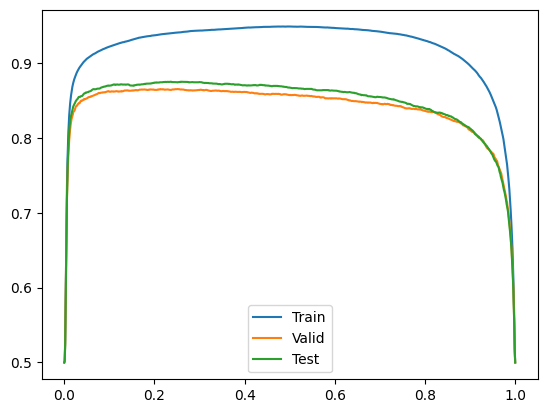

In [92]:
plt.plot(thresholds, acc_train, label='Train')
plt.plot(thresholds, acc_val, label='Valid')
plt.plot(thresholds, acc_test, label='Test')
plt.legend()

In [95]:
thresholds[acc_val.argmax()]

0.213

In [96]:
print('Test: ', accuracy_score(test_df_new['label_id'], h_test_new[:, 1] > 0.213))

Test:  0.9125714285714286


In [87]:
print(classification_report(test_df_new['label_id'], pred_test_new))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      3231
           1       0.94      0.88      0.91      3769

    accuracy                           0.91      7000
   macro avg       0.90      0.91      0.91      7000
weighted avg       0.91      0.91      0.91      7000

